### Datasets and Data Loaders

In [7]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):
    
    def __init__(self, root, data, transformations = None, im_files = [".jpg", ".png"]):
        
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(os.path.join(root, data, "images", f"*{[im_file for im_file in im_files]}")))]
        self.gt_paths = [im_path for im_path in sorted(glob(os.path.join(root, data, "labels", "*.txt")))]
        self.data, self.cls_counts, self.cls_names, count, data_count = {}, {}, {}, 0, 0
        for idx, (im_path, gt_path) in enumerate(zip(self.im_paths, self.gt_paths)):
            class_name = self.get_class_name(gt_path)
            self.data[im_path] = class_name
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
        
    def get_class_name(self, path): return os.path.basename(path).split("_")[0]
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = list(self.data.keys())[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[(self.data[im_path])]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
    
    tr_ds = CustomDataset(root = root, data = "train", transformations = transformations)
    vl_ds = CustomDataset(root = root, data = "valid", transformations = transformations)
    ts_ds = CustomDataset(root = root, data = "test", transformations = transformations)
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, tr_ds.cls_names

root = os.path.join(os.getcwd(), "data", "ogyeiv2", "ogyeiv2")
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

98
21
672
{'acc': 0, 'advil': 1, 'akineton': 2, 'algoflex': 3, 'algopyrin': 4, 'ambroxol': 5, 'apranax': 6, 'aspirin': 7, 'atoris': 8, 'atorvastatin': 9, 'betaloc': 10, 'bila': 11, 'c': 12, 'calci': 13, 'cataflam': 14, 'cetirizin': 15, 'co': 16, 'cold': 17, 'coldrex': 18, 'concor': 19, 'condrosulf': 20, 'controloc': 21, 'covercard': 22, 'coverex': 23, 'diclopram': 24, 'donalgin': 25, 'dorithricin': 26, 'doxazosin': 27, 'dulodet': 28, 'dulsevia': 29, 'enterol': 30, 'escitil': 31, 'favipiravir': 32, 'frontin': 33, 'furon': 34, 'ibumax': 35, 'indastad': 36, 'jutavit': 37, 'kalcium': 38, 'kalium': 39, 'ketodex': 40, 'koleszterin': 41, 'l': 42, 'lactamed': 43, 'lactiv': 44, 'laresin': 45, 'letrox': 46, 'lordestin': 47, 'magne': 48, 'mebucain': 49, 'merckformin': 50, 'meridian': 51, 'metothyrin': 52, 'mezym': 53, 'milgamma': 54, 'milurit': 55, 'naprosyn': 56, 'narva': 57, 'naturland': 58, 'nebivolol': 59, 'neo': 60, 'no': 61, 'noclaud': 62, 'nolpaza': 63, 'nootropil': 64, 'normodipine': 65, 

### Data Visualization

In [9]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(data = tr_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

RuntimeError: Numpy is not available

<Figure size 2000x1000 with 0 Axes>

In [10]:
visualize(data = val_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

RuntimeError: Numpy is not available

<Figure size 2000x1000 with 0 Axes>

In [11]:
visualize(data = ts_dl.dataset, n_ims = 20, rows = 4, cmap = "rgb", cls_names = list(classes.keys()))

RuntimeError: Numpy is not available

<Figure size 2000x1000 with 0 Axes>

### Data Analysis

/var/folders/9g/d2dbgbm100j6rmzw25wj9q080000gn/T/ipykernel_45617/1068038625.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)


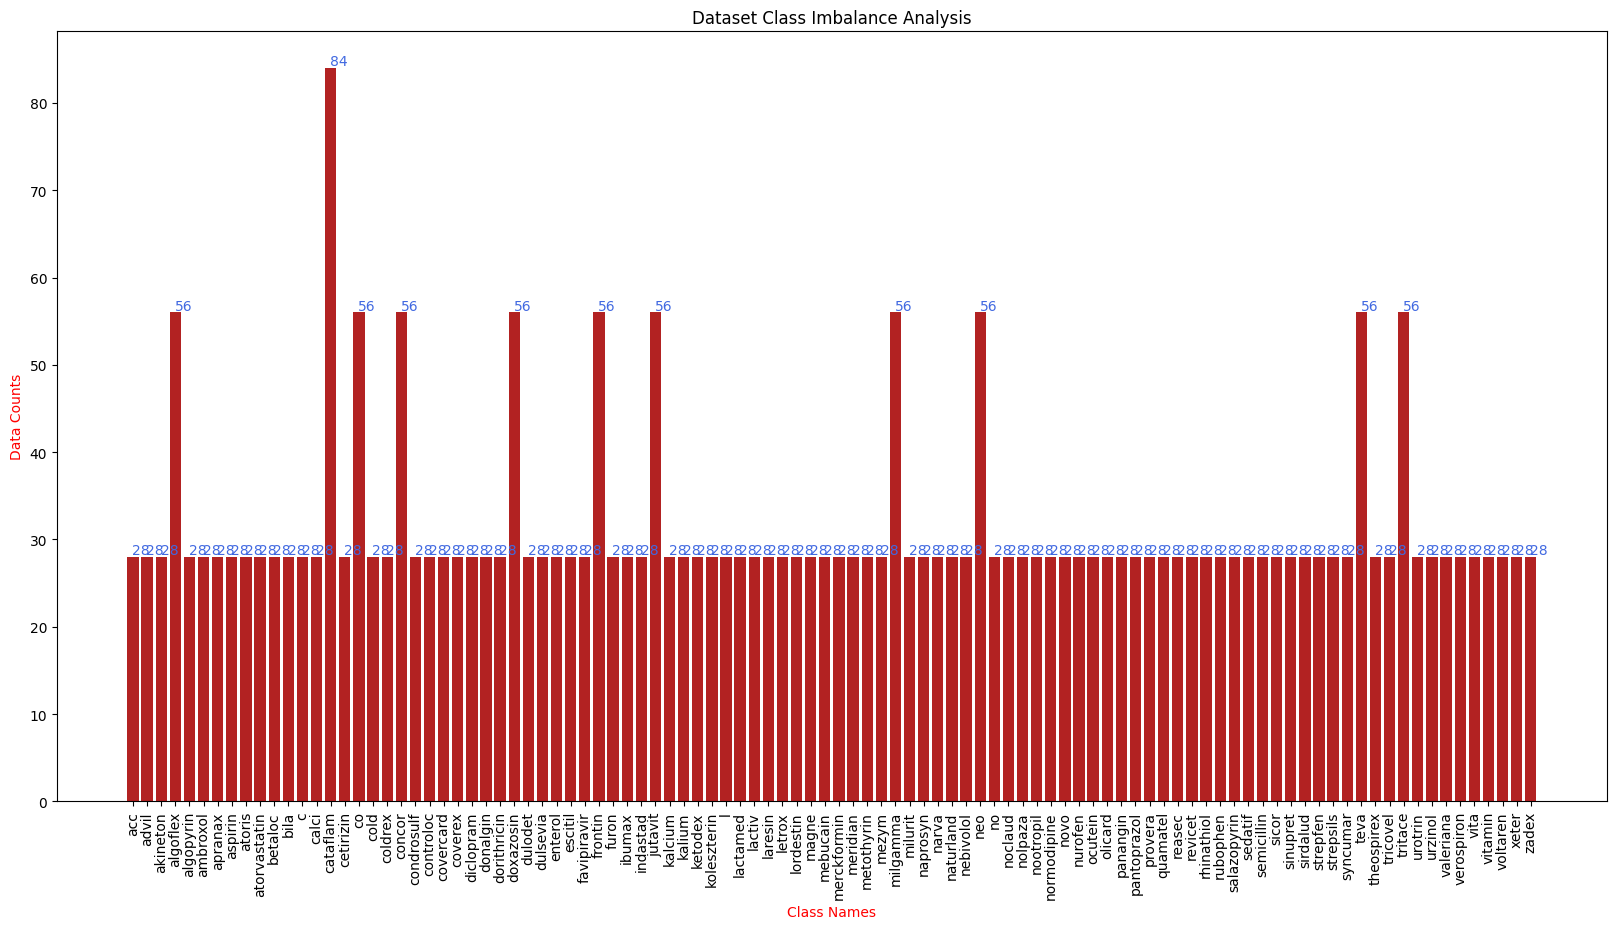

In [12]:
def data_analysis(root, data, transformations):
    
    ds = CustomDataset(root = root, data = data, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.8, 0.05
    text_height = 0.3
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 90)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, data = "train", transformations = tfs)

/var/folders/9g/d2dbgbm100j6rmzw25wj9q080000gn/T/ipykernel_45617/1068038625.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)


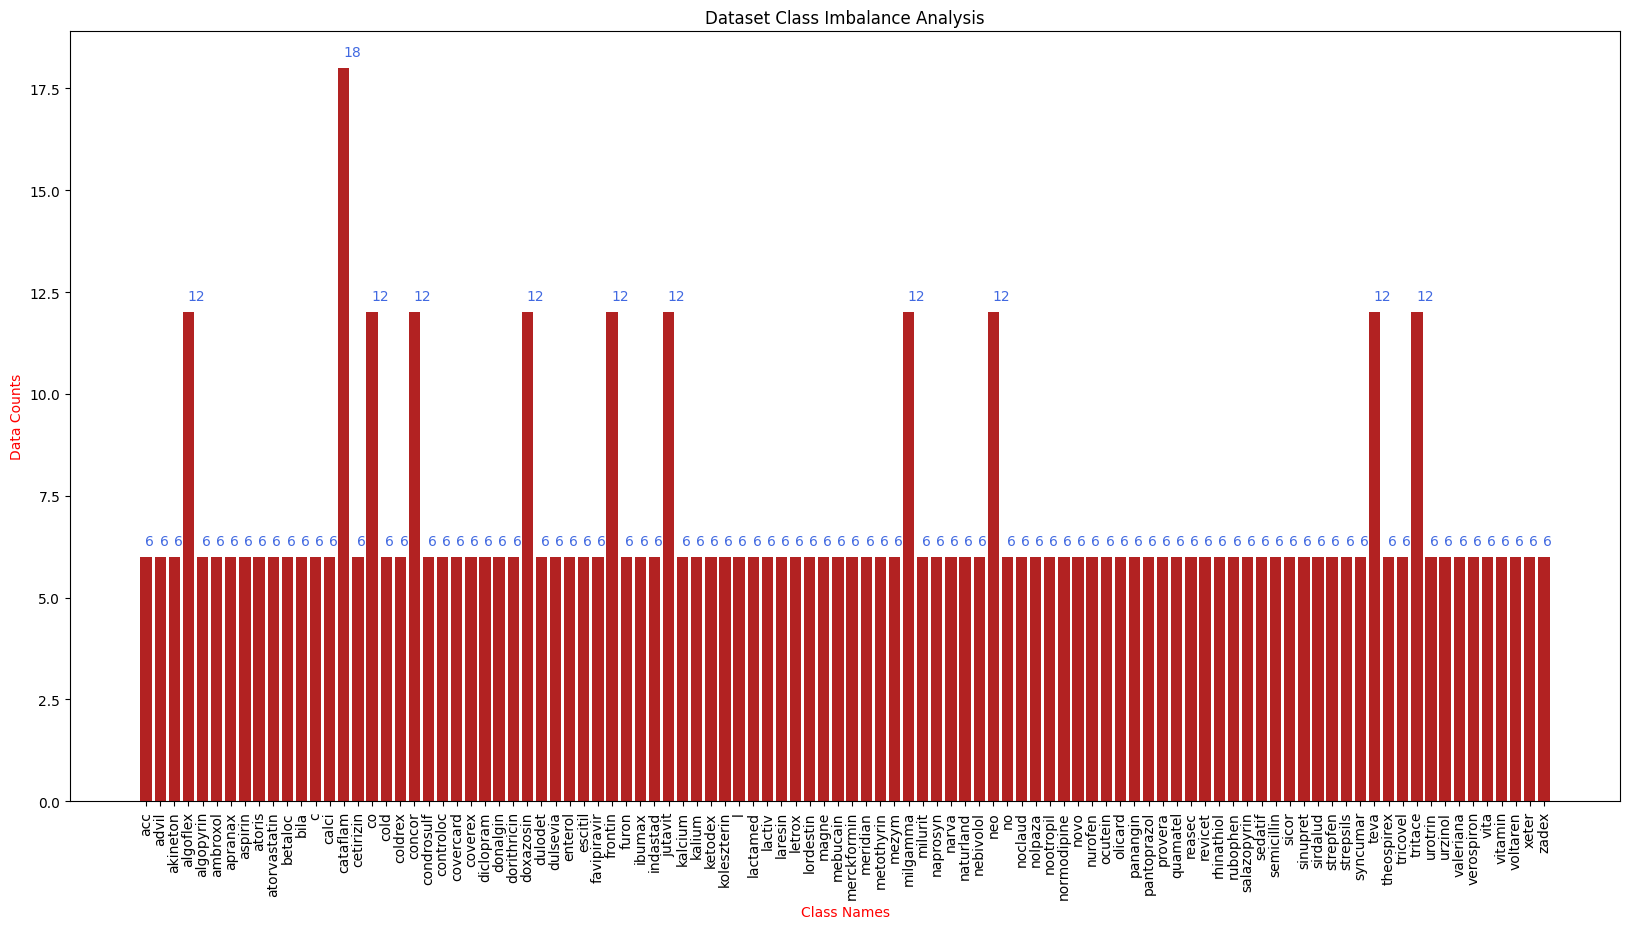

In [13]:
data_analysis(root = root, data = "valid", transformations = tfs)

/var/folders/9g/d2dbgbm100j6rmzw25wj9q080000gn/T/ipykernel_45617/1068038625.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 90)


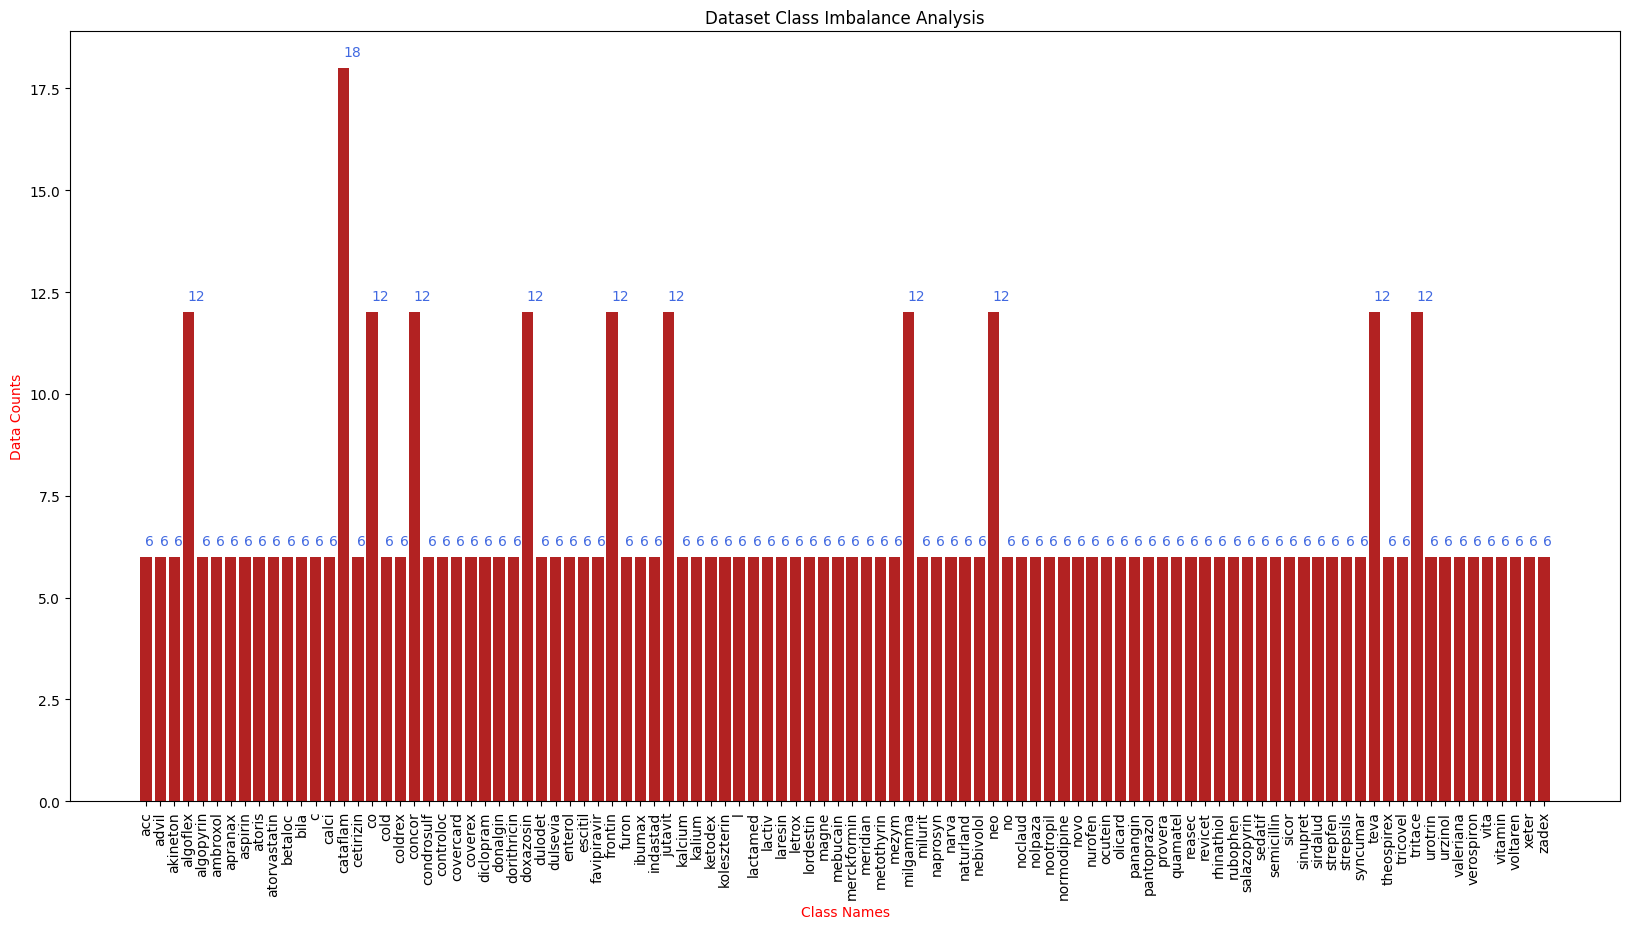

In [14]:
data_analysis(root = root, data = "test", transformations = tfs)

### Train and Validation

In [ ]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))  

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_setup(m): return m.to(device).eval(), 20, device, torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "pills", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<string>", line 1, in <module>
  File "/Users/atulp/Documents/VSC/HealthHack-2025/.conda/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/atulp/Documents/VSC/HealthHack-2025/.conda/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/atulp/Documents/VSC/HealthHack-2025/.conda/lib/python3.11/site-packages/torch/__init__.py", line 1477, in <module>
    from .functional import 

In [ ]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
    
    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "orangered")
    plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot([tr_f1.cpu() for tr_f1 in tr_f1s], label = "Train F1 Score", c = "orangered")
    plt.plot([val_f1.cpu() for val_f1 in val_f1s], label = "Validation F1 Score", c = "darkgreen")
    plt.xlabel("Epochs"); plt.ylabel("F1 Scores")
    plt.xticks(ticks = np.arange(len(tr_f1s)), labels = [i for i in range(1, len(tr_f1s) + 1)])
    plt.legend(); plt.show()
    
learning_curves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s)

: 

: 

: 

### Inference and Model Performance Analysis

In [ ]:
import cv2
class SaveFeatures():
    
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    
    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)

: 

: 

: 